## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Air-Sea CO₂ Flux, ECCO-Darwin Model v5 Data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

## About the Data

The ocean is a major sink for atmospheric carbon dioxide (CO2), largely due to the presence of phytoplankton that use the CO₂ to grow. Studies have shown that global ocean CO₂ uptake has increased over recent decades, however there is uncertainty in the various mechanisms that affect ocean CO₂ flux and storage and how the ocean carbon sink will respond to future climate change. Because CO₂ fluxes can vary significantly across space and time, combined with deficiencies in ocean and atmosphere CO₂ observations, there is a need for models that can thoroughly represent these processes. Ocean biogeochemical models (OBMs) have the ability to resolve the physical and biogeochemical mechanisms contributing to spatial and temporal variations in air-sea CO₂ fluxes but previous OBMs do not integrate observations to improve model accuracy and have not been able to operate on the seasonal and multi-decadal timescales needed to adequately characterize these processes. The ECCO-Darwin model is an OBM that assimilates Estimating the Circulation and Climate of the Ocean (ECCO) consortium ocean circulation estimates and biogeochemical processes from the Massachusetts Institute of Technology (MIT) Darwin Project. A pilot study using ECCO-Darwin was completed by [Brix et al. (2015)](https://doi.org/10.1016/j.ocemod.2015.07.008) however an improved version of the model was developed by [Carroll et al. (2020)](https://doi.org/10.1029/2019MS001888) in which issues present in the first model were addressed using data assimilation and adjustments were made to initial conditions and biogeochemical parameters. The updated ECCO-Darwin model was compared with interpolation-based products to estimate surface ocean partial pressure (pCO2) and air-sea CO₂ flux. This dataset contains the gridded global, monthly mean air-sea CO₂ fluxes from version 5 of the ECCO-Darwin model. The data are available at ~1/3° horizontal resolution at the equator (~18 km at high latitudes) from January 2020 through December 2022.

For more information regarding this dataset, please visit the [Air-Sea CO₂ Flux ECCO-Darwin Model](https://earth.gov/ghgcenter/data-catalog/eccodarwin-co2flux-monthgrid-v5) data overview page.

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Querying the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored. 

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import branca 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable 
# Name of the collection for ECCO Darwin CO₂ flux monthly emissions
collection_name = "eccodarwin-co2flux-monthgrid-v5"

In [3]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'requests' library allows a HTTP request possible
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

# Print the properties of the collection to the console
collection

{'id': 'eccodarwin-co2flux-monthgrid-v5',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5'}],
 'title': 'Air-Sea CO₂ Flux, ECCO-Darwin Model v5',
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['2020-01-01T00:00:00+00:00',
     '2022-12-31T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'renders': {'co2': {'assets': ['co2'],
   'nodata': 'nan',
   'rescale': [[-0.0007, 0.0002]],
   'colormap_name': 'bwr'},
  'dashboard': {'assets': ['co2'],
   'nodata': 'nan',
  

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2020 to December 2022. By looking at the `dashboard:time density`, we observe that the data is periodic with monthly time density.

In [4]:
# Extracting the required temporal information
temporal_extent = collection['extent']['temporal']['interval'][0]
start_date = temporal_extent[0].split('T')[0]
end_date = temporal_extent[1].split('T')[0]
temporal_resolution = collection['dashboard:time_density']

# Final print statement
print(f"Start Date = {start_date}")
print(f"End Date = {end_date}")
print(f"Temporal Resolution = {temporal_resolution}")

Start Date = 2020-01-01
End Date = 2022-12-31
Temporal Resolution = month


In [5]:
# Create a function that would search for a data collection in the US GHG Center STAC API

# First, we need to define the function
# The name of the function is "get_item_count" 
# The argument that will be passed to the defined function is "collection_id"
def get_item_count(collection_id):

    # Set a counter for the number of items existing in the collection 
    count = 0 

    # Define the path to retrieve the granules (items) of the collection of interest (Air-Sea CO2 Flux ECCO-Darwin model) in the STAC API
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items" 

    # Run a while loop to make HTTP requests until there are no more URLs associated with the collection (Air-Sea CO2 Flux ECCO-Darwin model) in the STAC API
    while True:

        # Retrieve information about the granules by sending a "get" request to the STAC API using the defined collection path 
        response = requests.get(items_url) 

        # If the items do not exist, print an error message and quit the loop
        if not response.ok:
            print("error getting items")
            exit()

        # Return the results of the HTTP response as JSON
        stac = response.json()

        # Increase the "count" by the number of items (granules) returned in the response
        count += int(stac["context"].get("returned", 0))

        # Retrieve information about the next URL associated with the collection (Air-Sea CO2 Flux ECCO-Darwin model) in the STAC API (if applicable)
        next = [link for link in stac["links"] if link["rel"] == "next"]

        # Exit the loop if there are no other URLs
        if not next:
            break
        
        # Ensure the information gathered by other STAC API links associated with the collection are added to the original path
        # "href" is the identifier for each of the tiles stored in the STAC API
        items_url = next[0]["href"]

    # Return the information about the total number of granules found associated with the collection (Air-Sea CO2 Flux ECCO-Darwin model)
    return count

In [6]:
# Apply the function created above "get_item_count" to the Air-Sea CO2 Flux ECCO-Darwin collection
number_of_items = get_item_count(collection_name)

# Get the information about the number of granules found in the collection
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 36 items


In [7]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

{'id': 'eccodarwin-co2flux-monthgrid-v5-202212',
 'bbox': [-180.125, -90.124826629681, 179.875, 89.875173370319],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5/items/eccodarwin-co2flux-monthgrid-v5-202212'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/stac/map?collection=eccodarwin-co2flux-monthgrid-v5&item=eccodarwin-co2flux-monthgrid-v5-202212&assets=co2&nodata=nan&rescale=-0.0007%2C0.0002&colormap_name=bwr',
   'rel': 'preview',
 

## Exploring Changes in CO₂ Levels Using the Raster API

In this notebook, we will explore the global changes of CO₂ flux over time in urban regions. We will visualize the outputs on a map using `folium`.

In [8]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"]: item for item in items}

# Next, we need to specify the asset name for this collection.
# The asset name is referring to the raster band containing the pixel values for the parameter of interest.
# For the case of the Air-Sea CO2 Flux ECCO-Darwin collection, the parameter of interest is “co2”.
asset_name = "co2"

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in the `rescale_values`.

In [9]:
# Fetch the minimum and maximum values for the CO2 value range
rescale_values = {"max":0.0007, "min":-0.0007}

Now, we will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. This step is done twice so that we can visualize two arbitrary events independently.

In [10]:
# Choose a color map for displaying the first observation (event)
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "magma"

# Make a GET request to retrieve information for the December 2022 tile which is the 1st item in the collection
# To retrieve the first item in the collection we use "0" in the "(items.keys())[0]" statement 
# If you want to select another item (granule) in the list (collection), you can refer to the Data Browser in the U.S. Greenhouse Gas Center website  
# URL to the Air-Sea CO2 Flux ECCO-Darwin collection in the US GHG Center: https://dljsq618eotzp.cloudfront.net/browseui/#eccodarwin-co2flux-monthgrid-v5/

# A GET request is made for the December 2022 tile
december_2022_tile = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[0]]['collection']}&item={items[list(items.keys())[0]]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling 
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
december_2022_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=eccodarwin-co2flux-monthgrid-v5&item=eccodarwin-co2flux-monthgrid-v5-202212&assets=co2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=-0.0007%2C0.0007'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.125, -90.124826629681, 179.875, 89.875173370319],
 'center': [-0.125, -0.1248266296809959, 0]}

In [11]:
# Make a GET request to retrieve information for the April 2021 tile which is the 21th item in the collection
# To retrieve the 21st item in the collection we use "20" in the "(items.keys())[20]" statement 
# Keep in mind that a list starts from 0, therefore "items[20]" is referring to the 21st item in the list/collection

# A GET request is made for the April 2021 tile
april_2021_tile = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[20]]['collection']}&item={items[list(items.keys())[20]]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console
april_2021_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=eccodarwin-co2flux-monthgrid-v5&item=eccodarwin-co2flux-monthgrid-v5-202104&assets=co2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=-0.0007%2C0.0007'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.125, -90.124826629681, 179.875, 89.875173370319],
 'center': [-0.125, -0.1248266296809959, 0]}

## Visualizing CO₂ flux Emissions

In [12]:
# For this study we are going to compare the CO2 level in 2021 and 2022 along the coast of California
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set the initial zoom level and center of map for both tiles
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


# Define the first map layer with the CO2 Flux data for December 2022
map_layer_1 = TileLayer(
    tiles=december_2022_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name='December 2022 CO2 Flux', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map 
map_layer_1.add_to(map_.m1)


# Define the second map layer with the CO2 Flux data for April 2021
map_layer_2 = TileLayer(
    tiles=april_2021_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution 
    name='April 2021 CO2 Flux', # Title for the layer
    overlay=True, # The layer can be overlaid on the map
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the second layer to the Dual Map 
map_layer_2.add_to(map_.m2)


# Display data markers (titles) on both maps
folium.Marker((40, 5.0), tooltip="both").add_to(map_)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add a legend to the dual map using the 'branca' library
# Note: the inserted legend is representing the minimum and maximum values for both tiles
# Minimum value = -0.0007, maximum value = 0.0007
colormap = branca.colormap.LinearColormap(colors=["#0000FF", "#3399FF", "#66CCFF", "#FFFFFF", "#FF66CC", "#FF3399", "#FF0000"], vmin=-0.0007, vmax=0.0007) 

# Add the data unit as caption 
colormap.caption = 'Millimoles per meter squared per second (mmol m²/s)'

# Define custom tick values for the legend bar
tick_val = [-0.0007, -0.00035, 0, 0.00035, 0.0007]

# Create a HTML representation
legend_html = colormap._repr_html_()

# Create a customized HTML structure for the legend
legend_html = f'''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; width: 400px; height: auto; background-color: rgba(255, 255, 255, 0.8);
             border-radius: 5px; border: 1px solid grey; padding: 10px; font-size: 14px; color: black;">
    <b>{colormap.caption}</b><br>
    <div style="display: flex; justify-content: space-between;">
        <div>{tick_val[0]}</div> 
        <div>{tick_val[1]}</div> 
        <div>{tick_val[2]}</div> 
        <div>{tick_val[3]}</div> 
        <div>{tick_val[4]}</div> 
    </div>
    <div style="background: linear-gradient(to right,
                {'#0000FF'}, {'#3399FF'} {20}%,
                {'#3399FF'} {20}%, {'#66CCFF'} {40}%,
                {'#66CCFF'} {40}%, {'#FFFFFF'} {50}%,
                {'#FFFFFF'} {50}%, {'#FF66CC'} {80}%,
                {'#FF66CC'} {80}%, {'#FF3399'}); height: 10px;"></div>
</div>
'''

# Display the legend and caption on the map
map_.get_root().html.add_child(folium.Element(legend_html))

# Visualize the Dual Map
map_

# Calculating Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon along the coast of California, United States. 

In [13]:
# Create a polygon for the area of interest (aoi)
california_coast_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-124.19, 37.86], # North-west bounding coordinate
                [-123.11, 37.86], # North-east bounding coordinate
                [-119.96, 33.16], # South-east bounding coordinate
                [-121.13, 33.16], # South-west bounding coordinate
                [-124.19, 37.86]  # North-west bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [14]:
# Create a new map to display the generated polygon
aoi_map = Map(
    
    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap", 

    # Define the spatial properties for the map
    location=[
        
    # Set the center of the map
        35, -120 
    ],
    
    # Set the zoom value
    zoom_start=7, 
)

# Insert the Coastal California polygon to the map
folium.GeoJson(california_coast_aoi, name="Coastal California").add_to(aoi_map)

# Visualize the map
aoi_map

Now that we created the polygon for the area of interest, we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.  

In [15]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (Coastal California polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the Coastal California boundaries to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (Coastal California polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Print the result
    print(result)

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"],
    }

Before we run the generated function in the previous step on a specific item (observation), we first check the total number of items available within the collection and retrieve the information regarding their start datetime.

In [16]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 36 items


In [17]:
# Examine the first item in the collection
items[0]

{'id': 'eccodarwin-co2flux-monthgrid-v5-202212',
 'bbox': [-180.125, -90.124826629681, 179.875, 89.875173370319],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/eccodarwin-co2flux-monthgrid-v5/items/eccodarwin-co2flux-monthgrid-v5-202212'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/stac/map?collection=eccodarwin-co2flux-monthgrid-v5&item=eccodarwin-co2flux-monthgrid-v5-202212&assets=co2&nodata=nan&rescale=-0.0007%2C0.0002&colormap_name=bwr',
   'rel': 'preview',
 

In [18]:
# Generate a for loop that iterates over all the existing items in the collection 
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["start_datetime"])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2022-12-01T00:00:00+00:00


Generate the statistics for the AOI

In [19]:
%%time 
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the "california_coast_aoi" polygon
stats = [generate_stats(item, california_coast_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-124.19, 37.86], [-123.11, 37.86], [-119.96, 33.16], [-121.13, 33.16], [-124.19, 37.86]]]}, 'properties': {'statistics': {'b1': {'min': -0.00010515466364758998, 'max': -1.6706644260170267e-05, 'mean': -6.659370120027267e-05, 'count': 84.27000427246094, 'sum': -0.005611851484665965, 'std': 2.0657340712768002e-05, 'median': -6.633380711657132e-05, 'majority': -0.00010515466364758998, 'minority': -0.00010515466364758998, 'unique': 104.0, 'histogram': [[10.0, 7.0, 9.0, 12.0, 17.0, 17.0, 17.0, 8.0, 6.0, 1.0], [-0.00010515466364758998, -9.630986170884801e-05, -8.746505977010604e-05, -7.862025783136406e-05, -6.97754558926221e-05, -6.093065395388012e-05, -5.208585201513816e-05, -4.324105007639618e-05, -3.439624813765421e-05, -2.5551446198912237e-05, -1.6706644260170267e-05]], 'valid_percent': 32.2, 'masked_pixels': 219.0, 'valid_pixels': 104.0, 'percentile_2': -0.00010359588859230771, 'percentile_98': -3.094126973869558e-05}

In [20]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': -0.00010515466364758998,
   'max': -1.6706644260170267e-05,
   'mean': -6.659370120027267e-05,
   'count': 84.27000427246094,
   'sum': -0.005611851484665965,
   'std': 2.0657340712768002e-05,
   'median': -6.633380711657132e-05,
   'majority': -0.00010515466364758998,
   'minority': -0.00010515466364758998,
   'unique': 104.0,
   'histogram': [[10.0, 7.0, 9.0, 12.0, 17.0, 17.0, 17.0, 8.0, 6.0, 1.0],
    [-0.00010515466364758998,
     -9.630986170884801e-05,
     -8.746505977010604e-05,
     -7.862025783136406e-05,
     -6.97754558926221e-05,
     -6.093065395388012e-05,
     -5.208585201513816e-05,
     -4.324105007639618e-05,
     -3.439624813765421e-05,
     -2.5551446198912237e-05,
     -1.6706644260170267e-05]],
   'valid_percent': 32.2,
   'masked_pixels': 219.0,
   'valid_pixels': 104.0,
   'percentile_2': -0.00010359588859230771,
   'percentile_98': -3.094126973869558e-05}},
 'datetime': '2022-12-01T00:00:00+00:00'}

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [21]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data 
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2022-12-01T00:00:00+00:00,-0.000105,-0.000017,-0.000067,84.270004,-0.005612,0.000021,-0.000066,-0.000105,-0.000105,104.0,"[[10.0, 7.0, 9.0, 12.0, 17.0, 17.0, 17.0, 8.0,...",32.2,219.0,104.0,-0.000104,-0.000031,2022-12-01 00:00:00+00:00
1,2022-11-01T00:00:00+00:00,-0.000053,0.000003,-0.000030,84.270004,-0.002561,0.000014,-0.000033,-0.000053,-0.000053,104.0,"[[5.0, 16.0, 12.0, 19.0, 9.0, 12.0, 9.0, 13.0,...",32.2,219.0,104.0,-0.000051,-0.000005,2022-11-01 00:00:00+00:00
2,2022-10-01T00:00:00+00:00,-0.000034,0.000039,-0.000004,84.270004,-0.000316,0.000018,-0.000006,-0.000034,-0.000034,104.0,"[[7.0, 12.0, 14.0, 19.0, 8.0, 14.0, 10.0, 12.0...",32.2,219.0,104.0,-0.000032,0.000027,2022-10-01 00:00:00+00:00
3,2022-09-01T00:00:00+00:00,-0.000047,0.000041,-0.000009,84.270004,-0.000771,0.000020,-0.000010,-0.000047,-0.000047,104.0,"[[6.0, 12.0, 17.0, 13.0, 9.0, 14.0, 16.0, 12.0...",32.2,219.0,104.0,-0.000046,0.000021,2022-09-01 00:00:00+00:00
4,2022-08-01T00:00:00+00:00,-0.000091,-0.000004,-0.000039,84.270004,-0.003260,0.000021,-0.000034,-0.000091,-0.000091,104.0,"[[2.0, 8.0, 5.0, 7.0, 9.0, 14.0, 18.0, 16.0, 1...",32.2,219.0,104.0,-0.000085,-0.000005,2022-08-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the fossil fuel emission time series (January 2020 -December 2022) available for the Coastal California area of the U.S. We can plot the data set using the code below:

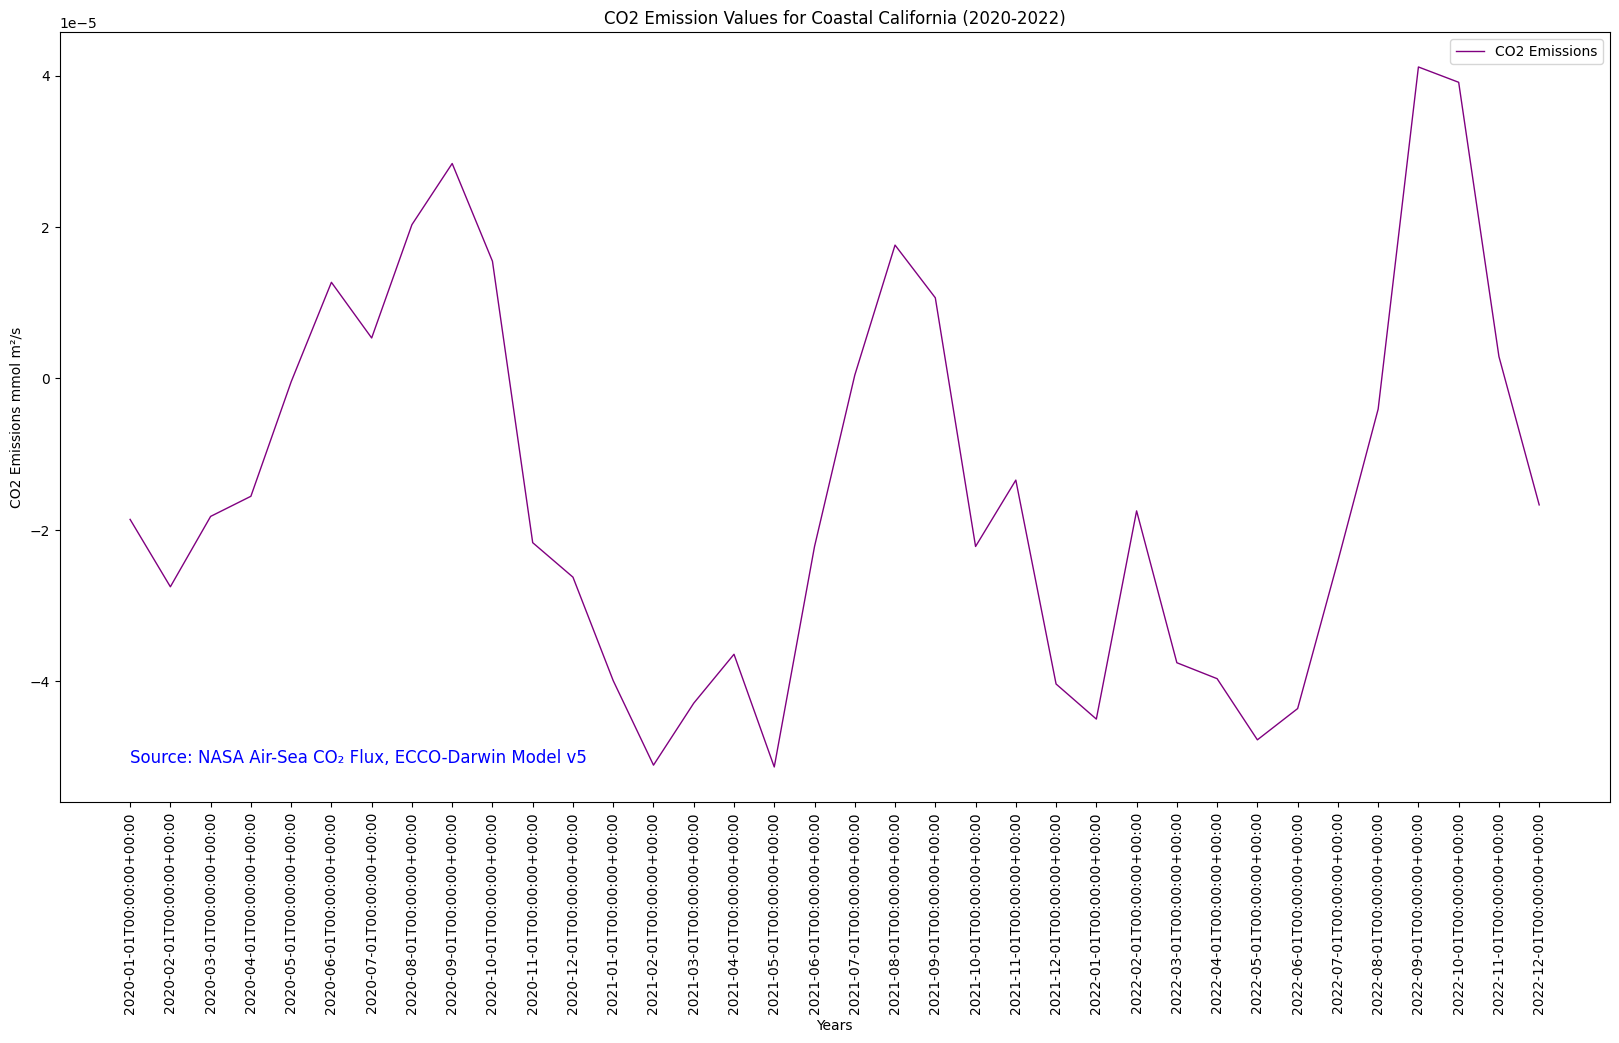

In [22]:
# Sort the DataFrame by the datetime column so the plot is displaying the values from left to right (2020 -> 2022)
df_sorted = df.sort_values(by="datetime")

# Plot the timeseries analysis of the monthly air-sea CO₂ flux changes along the coast of California
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df_sorted["datetime"],    # X-axis: sorted datetime
    df_sorted["max"],         # Y-axis: maximum CO₂ value
    color="purple",           # Line color
    linestyle="-",            # Line style
    linewidth=1,              # Line width
    label="CO2 Emissions",    # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("CO2 Emissions mmol m²/s")

# Insert title for the plot
plt.title("CO2 Emission Values for Coastal California (2020-2022)")

# Rotate x-axis labels to avoid cramping
plt.xticks(rotation=90)

# Add data citation
plt.text(
    df_sorted["datetime"].iloc[0],           # X-coordinate of the text (first datetime value)
    df_sorted["max"].min(),                  # Y-coordinate of the text (minimum CO2 value)

    # Text to be displayed
    "Source: NASA Air-Sea CO₂ Flux, ECCO-Darwin Model v5",                   
    fontsize=12,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="bottom",              # Vertical alignment
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

Looking at the plot above, we notice that CO₂ emission level increases particularly around 2022-09-01 for the defined area of interest. To take a closer look at monthly CO₂ flux variability across this region, we are going to retrieve and display data collected during the September 2022 observation. 

In [23]:
# The 2022-09-01 observation is the 4th item in the list. 
# Considering that a list starts with "0", we need to insert "3" in the "items[3]" statement
print(items[3]["properties"]["start_datetime"])

2022-09-01T00:00:00+00:00


In [24]:
# A GET request is made for the September 2022 tile
September2022_co2_flux = requests.get(

    # Pass the collection name, the item number in the list, and its ID
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[3]['collection']}&item={items[3]['id']}"

    # Pass the asset name
    f"&assets={asset_name}"

    # Pass the color formula and colormap for custom visualization
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"

    # Pass the minimum and maximum values for rescaling
    f"&rescale={rescale_values['min']},{rescale_values['max']}",

# Return the response in JSON format
).json()

# Print the properties of the retrieved granule to the console  
September2022_co2_flux

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=eccodarwin-co2flux-monthgrid-v5&item=eccodarwin-co2flux-monthgrid-v5-202209&assets=co2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=-0.0007%2C0.0007'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.125, -90.124826629681, 179.875, 89.875173370319],
 'center': [-0.125, -0.1248266296809959, 0]}

In [25]:
# Create a new map to display the September 2022 tile
aoi_map_bbox = Map(

    # Base map is set to OpenStreetMap
    tiles="OpenStreetMap",

    # Set the center of the map
    location=[
        34, -120
    ],

    # Set the zoom value
    zoom_start=5.5,
)

# Define the map layer with the CO2 flux data for September 2022
map_layer = TileLayer(
    tiles=September2022_co2_flux["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity = 0.7, # Adjust the transparency of the layer
)

# Add the layer to the map
map_layer.add_to(aoi_map_bbox)

# Add a legend to the map
# Minimum value = -0.0007, maximum value = 0.0007
colormap = branca.colormap.LinearColormap(colors=["#0000FF", "#3399FF", "#66CCFF", "#FFFFFF", "#FF66CC", "#FF3399", "#FF0000"], vmin=-0.0007, vmax=0.0007) 

# Add the data unit as caption 
colormap.caption = 'Millimoles per meter squared per second (mmol m²/s)'

# Define custom tick values for the legend bar
tick_val = [-0.0007, -0.00035, 0, 0.00035, 0.0007]

# Create a HTML representation
legend_html = colormap._repr_html_()

# Create a customized HTML structure for the legend
legend_html = f'''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; width: 400px; height: auto; background-color: rgba(255, 255, 255, 0.8);
             border-radius: 5px; border: 1px solid grey; padding: 10px; font-size: 14px; color: black;">
    <b>{colormap.caption}</b><br>
    <div style="display: flex; justify-content: space-between;">
        <div>{tick_val[0]}</div> 
        <div>{tick_val[1]}</div> 
        <div>{tick_val[2]}</div> 
        <div>{tick_val[3]}</div> 
        <div>{tick_val[4]}</div> 
    </div>
    <div style="background: linear-gradient(to right,
                {'#0000FF'}, {'#3399FF'} {20}%,
                {'#3399FF'} {20}%, {'#66CCFF'} {40}%,
                {'#66CCFF'} {40}%, {'#FFFFFF'} {50}%,
                {'#FFFFFF'} {50}%, {'#FF66CC'} {80}%,
                {'#FF66CC'} {80}%, {'#FF3399'}); height: 10px;"></div>
</div>
'''

# Display the legend and caption on the map
aoi_map_bbox.get_root().html.add_child(folium.Element(legend_html))

# Add the title to the map
title_html = '''
<div style="position: fixed; top: 10px; right: 10px; z-index: 1000; background-color: rgba(255, 255, 255, 0.8); border-radius: 5px; border: 1px solid grey; padding: 10px;">
    <b>Air-Sea CO₂ Flux, ECCO-Darwin</b><br>
    September 2022
</div>
'''
# Display the title on the map
aoi_map_bbox.get_root().html.add_child(folium.Element(title_html))

# Visualize the map
aoi_map_bbox

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the NASA Air-Sea CO₂ Flux ECCO Darwin dataset:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the CO₂ Flux levels over the Coastal California area for two distinctive months/years
5.	Create a table that displays the minimum, maximum, and sum of the CO₂ Flux values for a specified region
6.	Generate a time-series graph of the CO₂ Flux values for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 